In [1]:
%matplotlib inline 
!module load nvhpc 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
REDUCE_DATA = False

In [4]:
torch.cuda.is_available()

True

In [5]:
CUDA_NUM = 1

In [6]:
device = torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [7]:
# Load Data
sample_info = pd.read_csv("shared_data/cancer.samples", sep="\t")[
    ["sample", "project_descriptor", "sample_type"]
]
expression_df = (
    pd.read_feather("shared_data/expression_df.feather")
    .drop(["key"], axis=1)
    .transpose()
)
methylation_data_df = (
    pd.read_feather("shared_data/methylation_data_df.feather")
    .drop(["PMR_INDEX"], axis=1)
    .transpose()
)
sample_info = sample_info.set_index("sample")

In [8]:
input_data_df = expression_df.join(sample_info, how="inner")

# One-hot encode categorical variables
project_descriptor_encoded = pd.get_dummies(
    input_data_df["project_descriptor"], prefix="cancer_type"
)
sample_type_encoded = pd.get_dummies(input_data_df["sample_type"], prefix="sample_type")
data_df = pd.concat(
    [
        input_data_df.drop(["project_descriptor", "sample_type"], axis=1),
        project_descriptor_encoded,
        sample_type_encoded,
    ],
    axis=1,
)

# Scale Data
scaler = StandardScaler()
# expression_scaled = scaler.fit_transform(data_df.values.astype(np.float64))
expression_scaled = np.log1p(data_df.values.astype(np.float64))
expression_data = torch.tensor(expression_scaled).float()
meth_data = torch.tensor(methylation_data_df.values.astype(np.float64)).float() / 100
expression_data = np.hstack([np.ones((expression_data.shape[0], 1)), expression_data])
# Split Data
expression_data_train, expression_data_test, meth_data_train, meth_data_test = (
    train_test_split(expression_data, meth_data, test_size=0.33, random_state=42)
)

In [9]:
def reduce_data(x_data, y_data):
    num_data = int(0.20 * len(x_data))
    x_data_reduced = x_data[:num_data]
    y_data_reduced = y_data[:num_data]
    return x_data_reduced, y_data_reduced


In [10]:
if REDUCE_DATA:
    X_train, y_train = reduce_data(expression_data_train, meth_data_train)
    X_test, y_test = reduce_data(expression_data_test, meth_data_test)
else:
    X_train, y_train = expression_data_train, meth_data_train
    X_test, y_test = expression_data_test, meth_data_test

In [11]:


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

/tmp/ipykernel_3350520/481046610.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
/tmp/ipykernel_3350520/481046610.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()


In [12]:
@variational_estimator
class BayesianRegressor(nn.Module):

    def __init__(self, input_dim, output_dim, activation):
        super().__init__()
        # self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 512)
        self.blinear2 = BayesianLinear(512, output_dim)
        self.sigmoid = nn.Sigmoid()
        if activation == "relu":
            self.activation_function = nn.ReLU()
        else:
            self.activation_function = nn.Tanh()

    def forward(self, x):
        x_ = self.activation_function(self.blinear1(x))
        x_ = self.blinear2(x_)
        return self.sigmoid(x_)

In [13]:
def evaluate_regression(regressor, X, y, samples=100, std_multiplier=2):
    x = X.to(device)
    Y = y.to(device)
    regressor.eval()
    with torch.no_grad():
        preds = [regressor(x) for i in range(samples)]
        preds = torch.stack(preds)
        means = preds.mean(axis=0)
        stds = preds.std(axis=0)
        ci_upper = means + (std_multiplier * stds)
        ci_lower = means - (std_multiplier * stds)
        ic_acc = (ci_lower <= Y) * (ci_upper >= Y)
        ic_acc = ic_acc.float().mean()
    regressor.train()
    return ic_acc, (ci_upper >= Y).float().mean(), (ci_lower <= Y).float().mean()

In [14]:
input_size = X_train.size()[1]

In [15]:
out_put_size = y_train.size()[1]

In [16]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [17]:
def get_val_losses(regressor, dataloader, criterion, optimizer_samples=10):
    val_losses = []
    regressor.eval()
    with torch.no_grad():
        for i, (expression, methylation) in enumerate(dataloader):
            expression, methylation = expression.to(device), methylation.to(device)
            loss = regressor.sample_elbo(
                inputs=expression,
                labels=methylation,
                criterion=criterion,
                sample_nbr=optimizer_samples,
            )
            val_losses.append(loss.item())
    regressor.train()
    return np.mean(val_losses)

In [18]:
def plot_losses(train_losses, val_losses):
    plt.plot(np.arange(len(train_losses)), train_losses, label="Train Loss")
    plt.title("Linear Model Gene Expression to Methylaton")

    plt.xlabel("Train Time")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    x, val_loss = zip(*val_losses)
    plt.plot(x, val_loss, label="Val Loss")
    plt.title("Linear Model Gene Expression to Methylaton")

    plt.xlabel("Train Time")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [19]:
def pred_vs_actual(model, valloader):
    actual = []
    predicted = []
    model.eval()
    with torch.no_grad():
        for expression, methylation in valloader:

            expression, methylation = expression.to(device), methylation.to(device)
            pred = model(expression)
            actual.extend(methylation.cpu().numpy().flatten().tolist())
            predicted.extend(pred.cpu().numpy().flatten().tolist())

    pearson_corr, _ = pearsonr(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    # Plot the Results
    plt.scatter(actual, predicted)
    plt.xlabel("True Methylation Levels")
    plt.ylabel("Predicted Methylation Levels")
    plt.title("Neural Network Gene Expression Regressor Predictions vs True Values")
    plt.plot(
        [min(actual), max(predicted)],
        [min(actual), max(predicted)],
        "k--",
        lw=4,
    )

    x_text = min(actual) + (max(actual) - min(actual)) * 0.9
    y_text = min(predicted) + (max(predicted) - min(predicted)) * 0.05

    plt.text(
        x_text,
        y_text,
        f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
        fontsize=12,
    )

    plt.show()

In [20]:
def train(
    dataloader_train, dataloader_test, epochs, learning_rate, optimizer_samples, val_every
):
    regressor = BayesianRegressor(input_size, out_put_size, "relu").to(device)
    optimizer = optim.SGD(regressor.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    iteration = 0
    loop = tqdm(total=len(dataloader_train) * epochs)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        for i, (expression, methylation) in enumerate(dataloader_train):
            expression, methylation = expression.to(device), methylation.to(device)
            optimizer.zero_grad()

            loss = regressor.sample_elbo(
                inputs=expression,
                labels=methylation,
                criterion=criterion,
                sample_nbr=optimizer_samples,
            )
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            last_val_loss = None

            iteration += 1
            if iteration % val_every == 0:
                ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(
                    regressor, X_test, y_test, samples=25, std_multiplier=3
                )
                val_loss = get_val_losses(regressor, dataloader_test, criterion, optimizer_samples)
                val_losses.append((len(train_losses), val_loss))
                loop.set_description(
                    "CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}, ".format(
                        ic_acc, under_ci_upper, over_ci_lower
                    )
                    + "Train Loss: {:.4f}, Val Loss: {:.4f}".format(loss, val_loss)
                )
            loop.update(1)
    loop.close()
    return regressor, train_losses, val_losses

In [21]:
# Hyperparameters
learning_rates = [1e-4]
loss_samples = [10]
batch_sizes = [10]
epochs = [100]

Learning Rate: 0.0001, Optimizer Samples: 10, Batch Size: 10, Epochs: 100


  0%|          | 0/10900 [00:00<?, ?it/s]

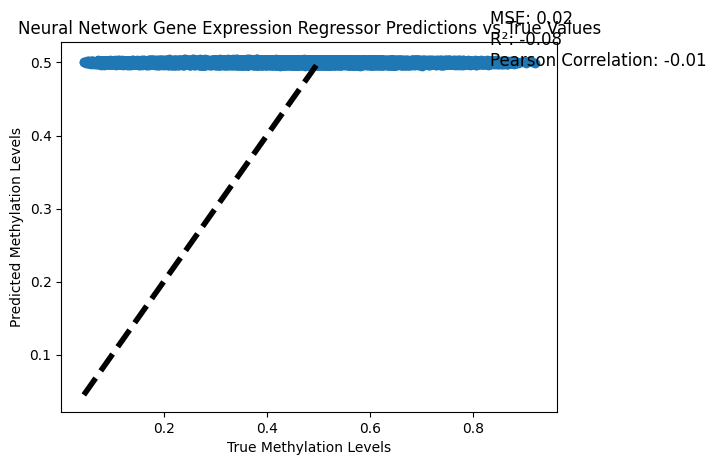

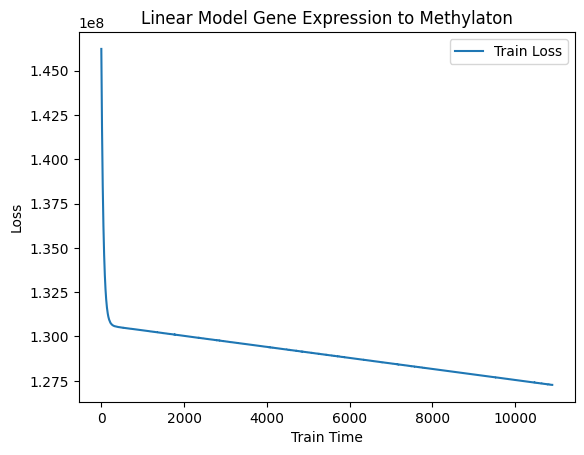

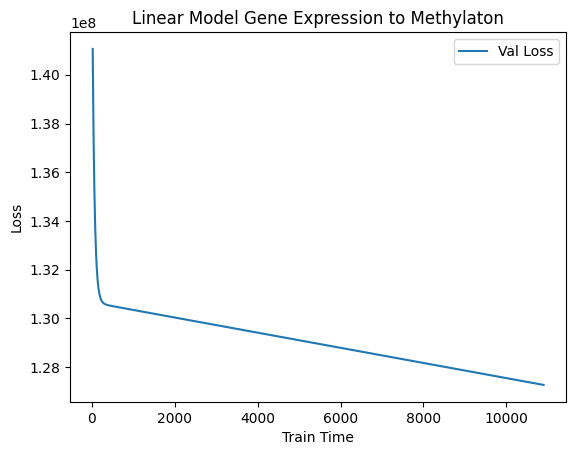

In [22]:
results = []
for e in epochs:
    for lr in learning_rates:
        for opt_s in loss_samples:
            for bs in batch_sizes:
                print(
                    f"Learning Rate: {lr}, Optimizer Samples: {opt_s}, Batch Size: {bs}, Epochs: {e}"
                )
                regressor, train_losses, val_losses = train(
                    dataloader_train,
                    dataloader_test,
                    epochs=e,
                    learning_rate=lr,
                    optimizer_samples=opt_s,
                    val_every=20,
                )
                pred_vs_actual(regressor, dataloader_test)
                plot_losses(train_losses, val_losses)
                results.append(
                    {
                        "learning_rate": lr,
                        "optimizer_samples": opt_s,
                        "batch_size": bs,
                        "epochs": e,
                        "regressor": regressor,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                    }
                )